In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:98% !important; }</style>"))
%load_ext autoreload  
%autoreload 2
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [2]:
import os
import sys
import argparse
import csv
import json
import time
import types, copy, pprint
from datetime import datetime
import numpy as np

if './src' not in sys.path:
    print(f"insert ./src")
    sys.path.insert(0, './src')
print(sys.path)


# import pandas as pd
# pd.options.display.width = 132
from scipy.sparse import csr_matrix

pp = pprint.PrettyPrinter(indent=4)
np.set_printoptions(edgeitems=3, infstr='inf', linewidth=150, nanstr='nan')

os.environ["WANDB_NOTEBOOK_NAME"] = "Adashare_Train.ipynb"
os.environ["CUDA_LAUNCH_BLOCKING"] = "1"

insert ./src
['./src', '/home/kevin/miniforge3/envs/ptsnnl/lib/python311.zip', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/lib-dynload', '', '/home/kevin/miniforge3/envs/ptsnnl/lib/python3.11/site-packages']


In [3]:
# print("1- '%x_%X'               : ",time.strftime('%x_%X'))
# print("2- '%X.%f'               : ",datetime.now().strftime('%X.%f'))
# print("3- '%X %x %Z'            : ",time.strftime('%X %x %Z'))
# print("4- '%D-%X.%f'            : ",datetime.now().strftime('%D-%X.%f'))
# print("5- '%Y-%m-%d %H:%M:%S.%f': ",datetime.now().strftime('%Y-%m-%d %H:%M:%S.%f'))
# print("6- '%Y%m%d_%H%M%S'       : ",datetime.now().strftime('%Y%m%d_%H%M%S'))
# print("7- '%Y_%m_%d_%H:%M:%S'   : ",datetime.now().strftime('%Y_%m_%d_%H:%M:%S'))

timestamp = datetime.now().strftime('%Y_%m_%d_%H:%M:%S')
print(' Timestamp: ','./tmp/sql_cohort'+'_'+timestamp+'.txt')

 Timestamp:  ./tmp/sql_cohort_2024_03_24_21:27:14.txt


In [4]:
import os
import logging 
logLevel = os.environ.get('LOG_LEVEL', 'INFO').upper()
FORMAT = '%(asctime)s - %(levelname)s: - %(message)s'
logging.basicConfig(level="INFO", format= FORMAT)
# logging.getLogger("imported_module").setLevel(logging.CRITICAL)
# logging.info(f" 1/7- engine connected")
# logging.warning(f" 1/7- engine connected")
# logging.error(f" 1/7- engine connected")
# logging.critical(f" 1/7- engine connected")

#### DB Connection

In [5]:
## Get ip address of Windows host from resolv.conf
# !cat /etc/hosts 
# !cat /etc/resolv.conf

In [6]:
# import psycopg2
# from sqlalchemy import create_engine

In [7]:
# LOCALDBHOST="MSI-GS76"
## Point to Host OS (Windows 10)
# DBHOST = "172.30.144.1"    
# DBHOST = "172.31.208.1"
# DBHOST = "172.20.240.1"
# DBHOST = "172.27.0.1"

In [8]:
# print(psycopg2.__version__)
# engine = create_engine(f"postgresql://kevin:Ahwaz22@{DBHOST}:5432?dbname=chembl_32") 
# conn = engine.connect()

# Setup

In [9]:
import torch
import torch.nn.functional as F
from torchinfo import summary
import os
import shutil
import sys
import getpass
from tqdm import tqdm
from datetime import datetime


In [10]:
torch.set_printoptions(precision=None, threshold=None, edgeitems=None, linewidth=150, profile=None, sci_mode=None)
def _get_device():
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    print("Running on:", device)
    return device
_get_device()

Running on: cuda


'cuda'

In [11]:
# Soft Nearest Neighbor Loss
# Copyright (C) 2020  Abien Fred Agarap
#
# This program is free software: you can redistribute it and/or modify
# it under the terms of the GNU Affero General Public License as published
# by the Free Software Foundation, either version 3 of the License, or
# (at your option) any later version.
#
# This program is distributed in the hope that it will be useful,
# but WITHOUT ANY WARRANTY; without even the implied warranty of
# MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
# GNU Affero General Public License for more details.
#
# You should have received a copy of the GNU Affero General Public License
# along with this program.  If not, see <https://www.gnu.org/licenses/>.
"""Sample module for using DNN classifier with SNNL"""
import argparse

import torch
from pt_datasets import create_dataloader, load_dataset

# from snnl.models import DNN
from snnl.utils import export_results, get_hyperparameters, set_global_seed
from snnl.utils.metrics import accuracy

__author__ = "Abien Fred Agarap"
__version__ = "1.0.0"

'Sample module for using DNN classifier with SNNL'

In [12]:
from dev_code import Model, DNN, Autoencoder, SNNLoss

In [13]:
def parse_args(input = None):
    parser = argparse.ArgumentParser(description="DNN classifier with SNNL")
    group = parser.add_argument_group("Parameters")
    group.add_argument(
        "-s",
        "--seed",
        required=False,
        default=1234,
        type=int,
        help="the random seed value to use, default: [1234]",
    )
    group.add_argument(
        "-m",
        "--model",
        required=False,
        default="baseline",
        type=str,
        help="the model to use, options: [baseline (default) | snnl]",
    )
    group.add_argument(
        "-c",
        "--configuration",
        required=False,
        default="examples/hyperparameters/dnn.json",
        type=str,
        help="the path to the JSON file containing the hyperparameters to use",
    )
    arguments = parser.parse_args(input)
    return arguments

In [14]:
# if __name__ == "__main__":
input_args = f" --seed              1234 " \
             f" --model             snnl" \
             f" --configuration     examples/hyperparameters/autoencoder.json"
             # f" --configuration     examples/hyperparameters/dnn_mnist.json"
             # f" --model             baseline" \
args = parse_args(input_args.split())

In [15]:
args

Namespace(seed=1234, model='snnl', configuration='examples/hyperparameters/autoencoder.json')

#### main(args)

In [16]:
## Autoencoder
(
    dataset,
    batch_size,
    epochs,
    learning_rate,
    input_shape,
    code_dim,
    snnl_factor,
    temperature,
) = get_hyperparameters(args.configuration)


hello autoencoder
hello C


In [17]:
units = [[784, 256], [256, 256], [256, 512], [512,10]]
epochs = 10
batch_size = 4

In [18]:
print(f"   dataset           {dataset}")
print(f"   batch_size        {batch_size}")
print(f"   epochs            {epochs}")
print(f"   learning_rate     {learning_rate}")
print(f"   code_dim             {code_dim}")
# print(f"   units             {units}")
print(f"   snnl_factor       {snnl_factor}")
print(f"   temperature       {temperature}")

   dataset           mnist
   batch_size        4
   epochs            10
   learning_rate     0.001
   code_dim             50
   snnl_factor       100.0
   temperature       None


In [19]:
set_global_seed(args.seed)

train_dataset, test_dataset = load_dataset(name=dataset)

In [20]:
train_dataset

Dataset MNIST
    Number of datapoints: 60000
    Root location: /home/kevin/datasets
    Split: Train
    StandardTransform
Transform: Compose(
               ToTensor()
               Normalize(mean=(0.1307,), std=(0.3081,))
           )

In [28]:
if dataset in ["mnist", "emnist"]:
    print(f"load {dataset}")
    train_dataset, test_dataset = load_dataset(name=dataset)

    if dataset == "emnist":
        print(f"dataset is emnist")
        train_features = train_dataset.data.numpy().astype("float32") / 255.0
        train_features = train_features[:60000]
        train_features = torch.from_numpy(train_features)
        train_labels = train_dataset.targets
        train_labels = train_labels[:60000]
        train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
        train_loader = create_dataloader(dataset=train_dataset, batch_size=batch_size)
    else:
        train_dataset, test_dataset = load_dataset(name=dataset)
        train_features = train_dataset.data.numpy().astype("float32") / 255.0
        train_features = train_features[:10000]
        train_features = torch.from_numpy(train_features)
        train_labels = train_dataset.targets
        train_labels = train_labels[:10000]
        train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
        train_loader = create_dataloader(dataset=train_dataset, batch_size=batch_size, num_workers=1)    


load mnist


#### Define autoencoder model

In [22]:
print(code_dim)
print(input_shape)
input_shape = 784
# input_shape = 1740
print(input_shape)

50
1740
784


In [23]:
if args.model.lower() == "baseline":
    model = Autoencoder(
        input_shape=input_shape, code_dim=code_dim, learning_rate=learning_rate
    )
elif args.model.lower() == "snnl":
    model = Autoencoder(
        input_shape=input_shape,
        code_dim=code_dim,
        learning_rate=learning_rate,
        use_snnl=True,
        factor=snnl_factor,
        temperature=temperature,
        mode="latent_code",
        code_units=30,
    )
else:
    raise ValueError("Choose between [baseline] and [snnl] only.")

 Building Base Model from NOTEBOOK
  Crtierion is : BCELoss()
  mode:  latent_code
 Build SNNLoss dfrom NOTEBOOK
 SNNLoss _init()_    -- mode: latent_code was found in SNNLoss._supported_modes --   is unsupervised: True
 SNNLoss _init()_    -- primary_criterion: BCELoss()
 Building Autoencoder from NOTEBOOK


#### Display model summary

In [24]:
col_names = [ "input_size",
                "output_size",
                "num_params",
                "params_percent",
                # "kernel_size",
                "mult_adds",
                "trainable"]
summary(model, input_size=(batch_size, 1, 28, 28), col_names = col_names)

Layer (type:depth-idx)                   Input Shape               Output Shape              Param #                   Param %                   Mult-Adds                 Trainable
Autoencoder                              [4, 1, 28, 28]            [4, 784]                  --                             --                   --                        True
├─ModuleList: 1-1                        --                        --                        --                             --                   --                        True
│    └─Linear: 2-1                       [4, 784]                  [4, 500]                  392,500                    11.24%                   1,570,000                 True
│    └─ReLU: 2-2                         [4, 500]                  [4, 500]                  --                             --                   --                        --
│    └─Linear: 2-3                       [4, 500]                  [4, 500]                  250,500                 

In [44]:
# for index, layer in enumerate(model.layers):
#     print(f" {index}:  ")
#     print(layer)
#     if isinstance(layer, torch.nn.Linear):
#         print(layer.weight.shape)

In [25]:
model.device

device(type='cuda', index=0)

### `main()`

In [51]:
epochs = 40

In [53]:
model.fit(data_loader=train_loader, epochs=epochs)

epoch 2/40 : mean loss = 861.149067
	recon loss = 0.262794	|	snn loss = 8.608863
epoch 4/40 : mean loss = 870.138482
	recon loss = 0.262799	|	snn loss = 8.698757
epoch 6/40 : mean loss = 868.386861
	recon loss = 0.262793	|	snn loss = 8.681241
epoch 8/40 : mean loss = 868.658920
	recon loss = 0.262780	|	snn loss = 8.683962
epoch 10/40 : mean loss = 863.865247
	recon loss = 0.262790	|	snn loss = 8.636025
epoch 12/40 : mean loss = 865.244675
	recon loss = 0.262788	|	snn loss = 8.649819
epoch 14/40 : mean loss = 879.991324
	recon loss = 0.262786	|	snn loss = 8.797285
epoch 16/40 : mean loss = 875.018653
	recon loss = 0.262784	|	snn loss = 8.747558
epoch 18/40 : mean loss = 875.069868
	recon loss = 0.262782	|	snn loss = 8.748071
epoch 20/40 : mean loss = 853.323628
	recon loss = 0.262775	|	snn loss = 8.530608
epoch 22/40 : mean loss = 865.807732
	recon loss = 0.262781	|	snn loss = 8.655449
epoch 24/40 : mean loss = 872.258426
	recon loss = 0.262767	|	snn loss = 8.719957
epoch 26/40 : mean l

In [38]:
test_features = test_dataset.data.reshape(-1, 784) / 255.0
model.eval()
model = model.cpu()
predictions = model.predict(test_features)
model.test_accuracy = accuracy(y_true=test_dataset.targets, y_pred=predictions)
print(f"accuracy: {model.test_accuracy}%")
# filename = f"DNN-{args.model.lower()}-{args.seed}.json"
# export_results(model=model, filename=filename)

DNN(
  (snnl_criterion): SNNLoss(
    (primary_criterion): CrossEntropyLoss()
  )
  (layers): ModuleList(
    (0): Linear(in_features=784, out_features=500, bias=True)
    (1): Linear(in_features=500, out_features=500, bias=True)
    (2): Linear(in_features=500, out_features=2000, bias=True)
    (3): Linear(in_features=2000, out_features=10, bias=True)
  )
)

accuracy: 98.03%


### Plot losses

In [44]:
model.train_loss
model.train_xent_loss
model.train_snn_loss

[23.557433570699487,
 23.22307972197837,
 23.17047405648739,
 23.135906503555624,
 23.111685691995824,
 23.109949184985872,
 23.07896597841953,
 23.061786400003637,
 23.07139054156364,
 23.056032813863553,
 23.049738750051944,
 23.052576990330472,
 23.038166687336375,
 23.038574340495657,
 23.027512424550157,
 23.02489833425968,
 23.02663789302745,
 23.02926631683999,
 23.033775702943192,
 23.02313812742842]

[0.49108011716223776,
 0.17844487679131488,
 0.12760246721036891,
 0.09754291860030052,
 0.07894913333052016,
 0.06346336329712512,
 0.05217743678454389,
 0.04229577096139497,
 0.03541186782036056,
 0.0296313617893673,
 0.02414795395303914,
 0.02002955710396488,
 0.01666371603991757,
 0.014435368990327449,
 0.010814445992892092,
 0.009346916684088238,
 0.007567327370510456,
 0.0064481989936308656,
 0.005928901349134902,
 0.004381614105597614]

[2.3066353371802797,
 2.3044634859612647,
 2.3042871525947084,
 2.3038363608908146,
 2.3032736605786264,
 2.304648591102438,
 2.302678856951125,
 2.3019490668114195,
 2.30359786520613,
 2.3026401469048032,
 2.302559077486079,
 2.3032547433325585,
 2.302150297164917,
 2.302413892745972,
 2.3016697934333314,
 2.3015551394604623,
 2.301907053399593,
 2.3022818159549794,
 2.3027846833492847,
 2.301875660267282]

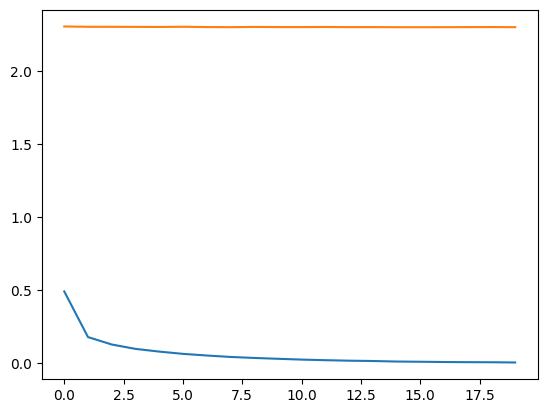

In [48]:
from matplotlib import pyplot as plt

plt.plot(model.train_xent_loss)
plt.plot(model.train_snn_loss)

#### Autoencoder `fit(data_loader = train_loader, epochs = epochs)` 

In [29]:
epoch =0 
data_loader = train_loader
if model.use_snnl:
    model.train_snn_loss = []
    model.train_recon_loss = []

In [30]:
print(f" epoch {epoch}  of {epochs} epochs")
# for epoch in range(epochs):

 epoch 0  of 10 epochs


In [31]:
# for epoch in range(epochs):

In [34]:
## epoch_loss = self.epoch_train(data_loader, epoch)

In [46]:
if type(epoch_loss) is tuple:
    self.train_loss.append(epoch_loss[0])
    self.train_snn_loss.append(epoch_loss[1])
    self.train_recon_loss.append(epoch_loss[2])
    if (epoch + 1) % show_every == 0:
        print(f"epoch {epoch + 1}/{epochs} : mean loss = {self.train_loss[-1]:.6f}")
        print(f"\trecon loss = {self.train_recon_loss[-1]:.6f}\t|\tsnn loss = {self.train_snn_loss[-1]:.6f}")
else:
    self.train_loss.append(epoch_loss)
    if (epoch + 1) % show_every == 0:
        print(f"epoch {epoch + 1}/{epochs} : mean loss = {self.train_loss[-1]:.6f}")

NameError: name 'epoch_loss' is not defined

In [ ]:
# epoch +=1

####  `epoch_train(model, data_loader, epoch)`

In [32]:
if model.use_snnl:
    epoch_primary_loss = 0
    epoch_snn_loss = 0
if model.name == "DNN" or model.name == "CNN":
    epoch_accuracy = 0
epoch_loss = 0

In [34]:
# for batch_features, batch_labels in data_loader:
batch_features, batch_labels = next(iter(data_loader))

In [35]:
print(f" batch features {batch_features.shape}   batch_labels: {batch_labels.shape}")

 batch features torch.Size([4, 28, 28])   batch_labels: torch.Size([4])


In [36]:
if model.name in ["Autoencoder", "DNN"]:
    batch_features = batch_features.view(batch_features.shape[0], -1)

print(f" batch features {batch_features.shape}   batch_labels: {batch_labels.shape}") 
print(batch_labels)
batch_labels = torch.tensor([9,5,5,9])
print(batch_labels)

 batch features torch.Size([4, 784])   batch_labels: torch.Size([4])
tensor([8, 2, 8, 6])
tensor([9, 5, 5, 9])


In [40]:
batch_features.shape
batch_features.max(1)
batch_features.min(1)

torch.Size([4, 784])

torch.return_types.max(
values=tensor([1., 1., 1., 1.]),
indices=tensor([154, 101, 406, 436]))

torch.return_types.min(
values=tensor([0., 0., 0., 0.]),
indices=tensor([0, 0, 0, 0]))

In [33]:
batch_features = batch_features.to(model.device)
batch_labels = batch_labels.to(model.device)
model.optimizer.zero_grad()

NameError: name 'batch_features' is not defined

In [38]:
outputs = model.forward(features=batch_features)

In [39]:
if model.use_snnl:
    train_loss, primary_loss, snn_loss = model.snnl_criterion(
        model=model,
        outputs=outputs,
        features=batch_features,
        labels=batch_labels,
        epoch=epoch,
    )
    print(f" train_loss {train_loss}, primary_loss {primary_loss}, snn_loss {snn_loss}")
    epoch_loss += train_loss.item()
    epoch_snn_loss += snn_loss.item()
    epoch_primary_loss += primary_loss.item()
else:
    train_loss = model.criterion(outputs, batch_labels if model.name == "DNN" or model.name == "CNN"  else batch_features,)
    epoch_loss += train_loss.item()

 train_loss 110.60186004638672, primary_loss 0.7075011730194092, snn_loss 1.0989435911178589


In [40]:
if model.name == "DNN" or model.name == "CNN":
    train_accuracy = (outputs.argmax(1) == batch_labels).sum().item() / len(batch_labels)
    epoch_accuracy += train_accuracy

train_loss.backward()

model.optimizer.step()
if model.use_snnl and model.temperature is not None:
    model.optimize_temperature()

    # break

#### End of dataloader loop

In [ ]:
epoch_loss /= len(data_loader)

if self.name in ["DNN", "CNN"]:
    epoch_accuracy /= len(data_loader)
    
if self.use_snnl:
    epoch_snn_loss /= len(data_loader)
    epoch_primary_loss /= len(data_loader)
    if self.name == "DNN" or self.name == "CNN":
        print(f" epoch_loss {epoch_loss}, epoch_snn_loss, {epoch_snn_loss},  epoch_primary_loss, {epoch_primary_loss}, epoch_accuracy,  {epoch_accuracy}")
        return epoch_loss, epoch_snn_loss, epoch_primary_loss, epoch_accuracy
    else:
        print(f" epoch_loss {epoch_loss}, epoch_snn_loss, {epoch_snn_loss},  epoch_primary_loss, {epoch_primary_loss}")
        return epoch_loss, epoch_snn_loss, epoch_primary_loss
else:
    if self.name == "DNN" or self.name == "CNN":
        print(f" epoch_loss {epoch_loss}, epoch_accuracy,  {epoch_accuracy}")
        return epoch_loss, epoch_accuracy
    else:
        print(f" epoch_loss {epoch_loss}")
        return epoch_loss

In [65]:
epoch_loss
batch_features.shape
# outputs[0].data
# outputs[1].data
batch_labels.data 
print(f" epoch_primary_loss  {epoch_primary_loss}")
print(f" epoch_snn_loss      {epoch_snn_loss}")
print(f" model.snnl_factor   {model.snnl_criterion.factor}")
print(f" epoch_loss          {epoch_loss}")
(outputs.argmax(1) == batch_labels).sum().item()
 
# train_accuracy
# epoch_accuracy
len(data_loader)

1152.2025146484375

torch.Size([4, 784])

tensor([8, 1, 7, 5], device='cuda:0')

 epoch_primary_loss  0.7071589231491089
 epoch_snn_loss      11.51495361328125
 model.snnl_factor   100.0
 epoch_loss          1152.2025146484375


0

2500

In [76]:
activations = dict()
layers = model.layers
for index, layer in enumerate(layers):
    if index == 0:
        activations[index] = layer(batch_features)
    else:
        activations[index] = layer(activations[index - 1])

In [78]:
for i in activations:
    print(activations[i].shape)

torch.Size([2, 256])
torch.Size([2, 256])
torch.Size([2, 512])
torch.Size([2, 10])


In [ ]:
epoch_loss /= len(data_loader)

if model.name in ["DNN", "CNN"]:
    epoch_accuracy /= len(data_loader)

if model.use_snnl:
    epoch_snn_loss /= len(data_loader)
    epoch_primary_loss /= len(data_loader)
    if model.name == "DNN" or model.name == "CNN":
        print(f" epoch_loss: {epoch_loss},  epoch_snn_loss: {epoch_snn_loss}, epoch_primaey_loss: {epoch_primary_loss}, accuracy: {epoch_accuracy} ")
        return epoch_loss, epoch_snn_loss, epoch_primary_loss, epoch_accuracy
    else:
        print(f" epoch_loss: {epoch_loss},  epoch_snn_loss: {epoch_snn_loss}, epoch_primary_loss: {epoch_primary_loss} ")
        return epoch_loss, epoch_snn_loss, epoch_primary_loss
else:
    if model.name == "DNN" or model.name == "CNN":
        print(f" epoch_loss: {epoch_loss}, accuracy: {epoch_accuracy} ")
        return epoch_loss, epoch_accuracy
    else:
        print(f" epoch_loss: {epoch_loss},")
        return epoch_loss

In [ ]:
# def main(args):
#     (
#         dataset,
#         batch_size,
#         epochs,
#         learning_rate,
#         units,
#         snnl_factor,
#         temperature,
#     ) = get_hyperparameters(args.configuration)

#     set_global_seed(args.seed)

#     train_dataset, test_dataset = load_dataset(name=dataset)
#     if dataset == "emnist":
#         train_features = train_dataset.data.numpy().astype("float32") / 255.0
#         train_features = train_features[:60000]
#         train_features = torch.from_numpy(train_features)
#         train_labels = train_dataset.targets
#         train_labels = train_labels[:60000]
#         train_dataset = torch.utils.data.TensorDataset(train_features, train_labels)
#     train_loader = create_dataloader(dataset=train_dataset, batch_size=batch_size)

#     if args.model.lower() == "baseline":
#         model = DNN(units=units, learning_rate=learning_rate)
#     elif args.model.lower() == "snnl":
#         model = DNN(
#             units=units,
#             learning_rate=learning_rate,
#             use_snnl=True,
#             factor=snnl_factor,
#             temperature=temperature,
#             use_annealing=False,
#         )
#     else:
#         raise ValueError("Choose between [baseline] and [snnl] only.")

#     model.fit(data_loader=train_loader, epochs=epochs)

#     test_features = test_dataset.data.reshape(-1, 784) / 255.0
#     model.eval()
#     model = model.cpu()
#     predictions = model.predict(test_features)
#     model.test_accuracy = accuracy(y_true=test_dataset.targets, y_pred=predictions)
#     print(f"accuracy: {model.test_accuracy}%")
#     filename = f"DNN-{args.model.lower()}-{args.seed}.json"
#     export_results(model=model, filename=filename)



#### SNNL Loss

In [154]:
snnl = SNNLoss(temperature=1.0)

 Build SNNLoss dfrom NOTEBOOK


In [170]:
_ = torch.manual_seed(42)
features = torch.rand((6, 4))
features

tensor([[0.8823, 0.9150, 0.3829, 0.9593],
        [0.3904, 0.6009, 0.2566, 0.7936],
        [0.9408, 0.1332, 0.9346, 0.5936],
        [0.8694, 0.5677, 0.7411, 0.4294],
        [0.8854, 0.5739, 0.2666, 0.6274],
        [0.2696, 0.4414, 0.2969, 0.8317]])

In [171]:
distance_matrix = snnl.pairwise_cosine_distance(features)
distance_matrix

tensor([[-1.1921e-07,  2.6181e-02,  2.1361e-01,  1.0087e-01,  2.2940e-02,  7.3328e-02],
        [ 2.6181e-02,  0.0000e+00,  2.7807e-01,  1.8148e-01,  9.0106e-02,  1.6577e-02],
        [ 2.1361e-01,  2.7807e-01,  5.9605e-08,  6.2519e-02,  1.6466e-01,  2.7426e-01],
        [ 1.0087e-01,  1.8148e-01,  6.2519e-02,  0.0000e+00,  7.5882e-02,  2.2894e-01],
        [ 2.2940e-02,  9.0106e-02,  1.6466e-01,  7.5882e-02,  1.1921e-07,  1.4981e-01],
        [ 7.3328e-02,  1.6577e-02,  2.7426e-01,  2.2894e-01,  1.4981e-01,  0.0000e+00]])

In [173]:
pairwise_distance_matrix = snnl.normalize_distance_matrix(features, distance_matrix, device = 'cpu')
torch.exp(-(distance_matrix / snnl.temperature)) 
# pairwise_distance_matrix = torch.exp(-(distance_matrix / snnl.temperature)) - torch.eye(features.shape[0])
# pairwise_distance_matrix.sum(1)   
pairwise_distance_matrix

tensor([[1.0000, 0.9742, 0.8077, 0.9041, 0.9773, 0.9293],
        [0.9742, 1.0000, 0.7572, 0.8340, 0.9138, 0.9836],
        [0.8077, 0.7572, 1.0000, 0.9394, 0.8482, 0.7601],
        [0.9041, 0.8340, 0.9394, 1.0000, 0.9269, 0.7954],
        [0.9773, 0.9138, 0.8482, 0.9269, 1.0000, 0.8609],
        [0.9293, 0.9836, 0.7601, 0.7954, 0.8609, 1.0000]])

tensor([[ 1.1921e-07,  9.7416e-01,  8.0767e-01,  9.0405e-01,  9.7732e-01,  9.2930e-01],
        [ 9.7416e-01,  0.0000e+00,  7.5725e-01,  8.3404e-01,  9.1383e-01,  9.8356e-01],
        [ 8.0767e-01,  7.5725e-01, -5.9605e-08,  9.3940e-01,  8.4818e-01,  7.6013e-01],
        [ 9.0405e-01,  8.3404e-01,  9.3940e-01,  0.0000e+00,  9.2693e-01,  7.9538e-01],
        [ 9.7732e-01,  9.1383e-01,  8.4818e-01,  9.2693e-01, -1.1921e-07,  8.6087e-01],
        [ 9.2930e-01,  9.8356e-01,  7.6013e-01,  7.9538e-01,  8.6087e-01,  0.0000e+00]])

In [174]:
# torch.sum(pairwise_distance_matrix, 1) ##.view(-1, 1)
# pairwise_distance_matrix / (1.0e-8 + torch.sum(pairwise_distance_matrix, 1).view(-1, 1))

sampling_probability = snnl.compute_sampling_probability(pairwise_distance_matrix)
sampling_probability.sum(1)
sampling_probability

tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000])

tensor([[ 2.5957e-08,  2.1212e-01,  1.7587e-01,  1.9685e-01,  2.1281e-01,  2.0235e-01],
        [ 2.1828e-01,  0.0000e+00,  1.6968e-01,  1.8688e-01,  2.0476e-01,  2.2039e-01],
        [ 1.9639e-01,  1.8413e-01, -1.4493e-08,  2.2842e-01,  2.0624e-01,  1.8483e-01],
        [ 2.0548e-01,  1.8956e-01,  2.1351e-01,  0.0000e+00,  2.1067e-01,  1.8078e-01],
        [ 2.1588e-01,  2.0186e-01,  1.8735e-01,  2.0475e-01, -2.6332e-08,  1.9016e-01],
        [ 2.1466e-01,  2.2719e-01,  1.7558e-01,  1.8372e-01,  1.9885e-01,  0.0000e+00]])

In [175]:
labels = torch.tensor([0,0,1,1,2,2])
# labels +=3
labels
labels.unsqueeze(1)
torch.eq(labels, labels.unsqueeze(1))

tensor([0, 0, 1, 1, 2, 2])

tensor([[0],
        [0],
        [1],
        [1],
        [2],
        [2]])

tensor([[ True,  True, False, False, False, False],
        [ True,  True, False, False, False, False],
        [False, False,  True,  True, False, False],
        [False, False,  True,  True, False, False],
        [False, False, False, False,  True,  True],
        [False, False, False, False,  True,  True]])

In [176]:
summed_masked_pick_probability = snnl.mask_sampling_probability(labels, sampling_probability)
# summed_masked_pick_probability.sum(0)
summed_masked_pick_probability

masking_matrix
tensor([[1., 1., 0., 0., 0., 0.],
        [1., 1., 0., 0., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 1., 1., 0., 0.],
        [0., 0., 0., 0., 1., 1.],
        [0., 0., 0., 0., 1., 1.]])
masked_pick_probabliltiy
tensor([[ 2.5957e-08,  2.1212e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 2.1828e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00, -1.4493e-08,  2.2842e-01,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  2.1351e-01,  0.0000e+00,  0.0000e+00,  0.0000e+00],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00, -2.6332e-08,  1.9016e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  0.0000e+00,  1.9885e-01,  0.0000e+00]])


tensor([0.2121, 0.2183, 0.2284, 0.2135, 0.1902, 0.1988])

#### Base Model

#### DNN

'Feed-forward Neural Network'

#### Autoencoder

#### Predict

In [ ]:
test_features = test_dataset.data.reshape(-1, 784) / 255.0

In [ ]:
model.eval()
model = model.cpu()

In [ ]:
predictions = model.predict(test_features)
model.test_accuracy = accuracy(y_true=test_dataset.targets, y_pred=predictions)

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
print(f"accuracy: {model.test_accuracy}%")

In [ ]:
filename = f"DNN-{args.model.lower()}-{args.seed}.json"
export_results(model=model, filename=filename)